In [1]:
from utils import *
import numpy as np
import random

In [62]:
def normalize_grad_norm_(parameters) -> torch.Tensor:
    if isinstance(parameters, torch.Tensor):
        parameters = [parameters]
    parameters = [p for p in parameters if p.grad is not None]
    if len(parameters) == 0:
        return torch.tensor(0.)
    device = parameters[0].grad.device
    total_norm = torch.norm(torch.stack([torch.norm(p.grad.detach()).to(device) for p in parameters]))
    coef = 1/total_norm
    for p in parameters:
        p.grad.detach().mul_(coef.to(p.grad.device))
    return total_norm

def turn_off_bias_grad(net):
    for l in net:
        if isinstance(l, nn.Linear):
            l.bias.requires_grad = False
            
def zero_bias(net):
    for l in net:
        if isinstance(l, nn.Linear):
            l.bias.data = torch.zeros_like(l.bias.data)

In [2]:
n1 = nn.Sequential(nn.Linear(5,5),nn.Linear(5,1))
n1[0].weight.data = n1[0].weight.data.type(torch.float64)
n1[1].weight.data = n1[1].weight.data.type(torch.float64)
n1[0].bias.data = n1[0].bias.data.type(torch.float64)
n1[1].bias.data = n1[1].bias.data.type(torch.float64)

n1[0].bias.data = torch.zeros_like(n1[0].bias.data)
n1[1].bias.data = torch.zeros_like(n1[1].bias.data)

n1_copy = nn.Sequential(nn.Linear(5,5),nn.Linear(5,1))
copy_weights(n1, n1_copy)
n1_copy[0].weight.data = n1[0].weight.data.type(torch.float64)
n1_copy[1].weight.data = n1[1].weight.data.type(torch.float64)
n1_copy[0].bias.data = n1[0].bias.data.type(torch.float64)
n1_copy[1].bias.data = n1[1].bias.data.type(torch.float64)

n1[0].bias.requires_grad = False
n1[1].bias.requires_grad = False
n1_copy[0].bias.requires_grad = False
n1_copy[1].bias.requires_grad = False

In [3]:
batch_size = 1000
x = 10*torch.randn(batch_size,5, dtype=torch.float64)
targets = 2*torch.randn(batch_size,1, dtype=torch.float64)
criterion = nn.MSELoss()

In [4]:
(n1[0].weight.data - n1_copy[0].weight.data).abs().max()

tensor(0., dtype=torch.float64)

In [5]:
# v = 2*torch.ones_like(v)
v = 1.5*torch.rand(5, dtype=torch.float64) + 0.5
diag_mat = torch.diag(v)
diag_mat_inv = torch.diag(1/v)
n1[0].weight.data = torch.matmul(diag_mat, n1[0].weight.data)
# n1[0].bias.data = torch.matmul(diag_mat, n1[0].bias.data)
n1[1].weight.data = torch.matmul(n1[1].weight.data, diag_mat_inv)

In [6]:
(n1[0].weight.data - n1_copy[0].weight.data).abs().max()

tensor(0.3138, dtype=torch.float64)

In [7]:
diag_mat_sq = torch.matmul(diag_mat, diag_mat)
diag_mat_inv_sq = torch.matmul(diag_mat_inv, diag_mat_inv)

In [8]:
optim1 = torch.optim.SGD(n1.parameters(), lr = 1)
optim2 = torch.optim.SGD(n1_copy.parameters(), lr = 1)

In [9]:
(n1(x) - n1_copy(x)).abs().max()l.bias.data

tensor(2.2204e-15, dtype=torch.float64, grad_fn=<MaxBackward1>)

In [10]:
optim1.zero_grad()
out1 = n1(x)
loss1 = criterion(out1, targets)
loss1.backward()
gradiants_n1 = []
for l in n1:
    gradiants_n1.append(l.weight.grad)
    print(l.weight.grad)

tensor([[-10.6191,   2.7505,   0.4137,  -0.9133,  -3.6858],
        [-24.1424,   6.2531,   0.9405,  -2.0764,  -8.3795],
        [  6.2442,  -1.6173,  -0.2433,   0.5370,   2.1673],
        [ -6.5466,   1.6956,   0.2550,  -0.5630,  -2.2723],
        [  1.7463,  -0.4523,  -0.0680,   0.1502,   0.6061]],
       dtype=torch.float64)
tensor([[25.0421,  9.7548,  0.8253,  9.1209, -5.6090]], dtype=torch.float64)


In [11]:
optim2.zero_grad()
out2 = n1_copy(x)
loss2 = criterion(out2, targets)
loss2.backward()
gradiants_copy = []
for l in n1_copy:
    gradiants_copy.append(l.weight.grad)
    print(l.weight.grad)

tensor([[-10.8847,   2.8193,   0.4240,  -0.9361,  -3.7780],
        [-12.3701,   3.2040,   0.4819,  -1.0639,  -4.2935],
        [ 10.7702,  -2.7896,  -0.4196,   0.9263,   3.7382],
        [ -9.0210,   2.3365,   0.3514,  -0.7759,  -3.1311],
        [  1.9491,  -0.5048,  -0.0759,   0.1676,   0.6765]],
       dtype=torch.float64)
tensor([[24.4310, 19.0381,  0.4785,  6.6191, -5.0256]], dtype=torch.float64)


In [12]:
(torch.matmul(diag_mat_inv, gradiants_copy[0]) - gradiants_n1[0]).abs().max()

tensor(7.1054e-15, dtype=torch.float64)

In [13]:
(torch.matmul(gradiants_copy[1], diag_mat) - gradiants_n1[1]).abs().max()

tensor(2.4869e-14, dtype=torch.float64)

In [14]:
# assign gradients
n1_copy[0].weight.grad = torch.matmul(diag_mat_inv_sq, gradiants_copy[0])
n1_copy[1].weight.grad = torch.matmul(gradiants_copy[1], diag_mat_sq)

In [15]:
n1[1].weight.grad

tensor([[25.0421,  9.7548,  0.8253,  9.1209, -5.6090]], dtype=torch.float64)

In [16]:
optim1.step()
optim2.step()

In [17]:
(n1(x) - n1_copy(x)).abs().max()

tensor(7.2760e-12, dtype=torch.float64, grad_fn=<MaxBackward1>)

In [51]:
net = nn.Sequential(nn.Linear(5,5),nn.Linear(5,1))
batch_size = 1000
x = 10*torch.randn(batch_size,5)
targets = 2*torch.randn(batch_size,1)
criterion = nn.MSELoss()

In [177]:
net_seed = np.random.randint(0,100000)
start, stop, step = 0, 0.1, 0.001

exp_seeds = ['original_grad'] + list(range(0,9,1))

all_exp = {}
for exp_s in exp_seeds:
    print(exp_s)
    lr_loss = []
    if exp_s == 'original_grad':
        for lr in np.linspace(start, stop, int((stop-start)/step)+1):
            net = Sequential_modified([5,5,1], net_seed)
            zero_bias(net)
            turn_off_bias_grad(net)
            optim = torch.optim.SGD(net.parameters(), lr=lr)
            optim.zero_grad()
            out = net(x)
            loss = criterion(out, targets)
            loss.backward()
            normalize_grad_norm_(net.parameters())
            optim.step()
            out = net(x)
            loss = criterion(out, targets)
            lr_loss.append((lr, loss.item()))
    else:
        exp_s = np.random.randint(0,100000)
        torch.manual_seed(exp_s)
        v = 1.5*torch.rand(5) + 0.5
        diag_mat = torch.diag(v)
        diag_mat_inv = torch.diag(1/v)
        diag_mat_sq = torch.matmul(diag_mat, diag_mat)
        diag_mat_inv_sq = torch.matmul(diag_mat_inv, diag_mat_inv)
        for lr in np.linspace(start, stop, int((stop-start)/step)+1):
            net = Sequential_modified([5,5,1], net_seed)
            zero_bias(net)
            turn_off_bias_grad(net)
            optim = torch.optim.SGD(net.parameters(), lr=lr)
            optim.zero_grad()
            out = net(x)
            loss = criterion(out, targets)
            loss.backward()
            
            net[0].weight.grad = torch.matmul(diag_mat_inv_sq, net[0].weight.grad)
            net[2].weight.grad = torch.matmul(net[2].weight.grad, diag_mat_sq)
            
            normalize_grad_norm_(net.parameters())
            optim.step()
            out = net(x)
            loss = criterion(out, targets)
            lr_loss.append((lr, loss.item()))
    all_exp.update({str(exp_s):lr_loss})

original_grad
0
1
2
3
4
5
6
7
8


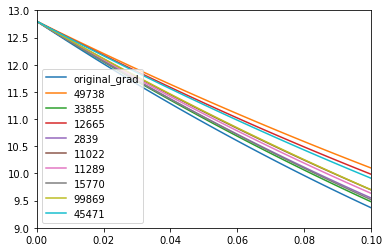

In [181]:
import matplotlib.pyplot as plt
for key, data in all_exp.items():
#     print(key)
#     plt.figure()
    lr, loss = zip(*data)
    plt.plot(lr, loss)
    plt.ylim([9, 13])
    plt.xlim([0, 0.1])
plt.legend(all_exp.keys())

In [ ]:
(((n1[0].weight.grad).norm())**2 + ((n1[1].weight.grad).norm())**2)**(1/2)

In [37]:
norm_ = normalize_grad_norm_(n1.parameters())

In [40]:
norm_ = normalize_grad_norm_(n1.parameters())

In [41]:
norm_

tensor(1., dtype=torch.float64)

In [73]:
net = Sequential_modified([5,5,1], 1)

In [76]:
net[0].bias.requires_grad

False

In [75]:
turn_grad_off(net)

Sequential_modified(
  (0): Linear(in_features=5, out_features=5, bias=True)
  (1): ReLU()
  (2): Linear(in_features=5, out_features=1, bias=True)
)

In [65]:
net[0].bias

Parameter containing:
tensor([0., 0., 0., 0., 0.])

In [64]:
zero_bias(net)

In [153]:
def calc_loss(p):
    return abs(p[0]*p[1] + 10)

In [468]:
start, stop, step = 0, 0.1, 0.000001

a, b = 2, 3
alpha = 3

p_loss = []
p_alpha_loss = []
for lr in np.linspace(start, stop, int((stop-start)/step)+1):
    p = np.array([a, b])
    p_alpha = np.array([a*alpha, b/alpha])
    p_grad = np.array([b, a])
    p_grad_normalized = p_grad/np.linalg.norm(p_grad)
    
    p_alpha_grad = np.array([b/alpha, a*alpha])
    p_alpha_grad_normalized = p_alpha_grad/np.linalg.norm(p_alpha_grad)
    
    p_alpha_grad_equiv = np.array([b/(alpha**2), a*(alpha**2)])
    p_alpha_grad_equiv_normalized = p_alpha_grad_equiv/np.linalg.norm(p_alpha_grad_equiv)
    
    p_alpha_grad_equiv_normalized = np.array([p_alpha_grad_normalized[0]/alpha, p_alpha_grad_normalized[1]*alpha])
    p_alpha_grad_equiv_normalized = p_alpha_grad_equiv_normalized/np.linalg.norm(p_alpha_grad_equiv_normalized)
    
    p_new = p - lr*p_grad_normalized
#     p_alpha_new___ = p - lr*p_alpha_grad_equiv_normalized ####
#     p_alpha_new = p_alpha - lr*p_alpha_grad_normalized
    
#     p_alpha_new = p - lr*p_alpha_grad_equiv_normalized ####
    p_alpha_new = p_alpha - lr*p_alpha_grad_normalized
    
    p_loss.append((lr, calc_loss(p_new)))
    p_alpha_loss.append((lr, calc_loss(p_alpha_new)))

In [469]:
all_exp = {}
all_exp.update({'p':p_loss})
all_exp.update({'p_alpha':p_alpha_loss})

15.644060257068986
15.393345368591799


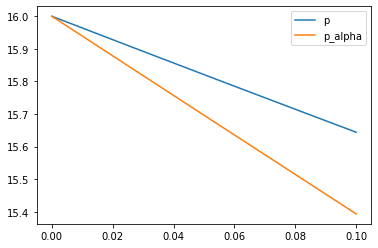

In [470]:
import matplotlib.pyplot as plt
for key, data in all_exp.items():
#     print(key)
#     plt.figure()
    lr, loss = zip(*data)
    plt.plot(lr, loss)
#     plt.ylim([10, 17])
    print(loss[-1])
plt.legend(all_exp.keys())

In [450]:
# p_alpha_new
a*alpha - lr*

SyntaxError: invalid syntax (<ipython-input-450-3aba30ed73bb>, line 2)

In [430]:
p_alpha_new[0]*p_alpha_new[1] - p_alpha_new___[0]*p_alpha_new___[1]

-1.7957479897135968

In [432]:
1.999985*2.99900011

5.99795523499835

In [433]:
alpha**2

100

In [434]:
p_new[0]*p_new[1] - p_alpha_new[0]*p_alpha_new[1]

1.6441352781565683

In [426]:
p_alpha_new

array([19.99985002,  0.29000112])

In [10]:
net1 = Sequential_modified([5,5,5,1], seed=100)

In [11]:
net2 = Sequential_modified_2([5,5,5,1], seed=100)

In [12]:
optim1 = torch.optim.SGD(net1.parameters(), lr=1)
optim2 = torch.optim.SGD(net2.parameters(), lr=1)

In [13]:
batch_size = 1000
x = 10*torch.randn(batch_size,5)
targets = 2*torch.randn(batch_size,1)
criterion = nn.MSELoss()

In [14]:
optim1.zero_grad()
net1 = diagonal_matrix_symmetry_balanced_3(net1, 2, 100)
out1 = net1(x)
loss1 = criterion(out1, targets)
loss1.backward()
optim1.step()

optim2.zero_grad()
out2 = net2(x)
loss2 = criterion(out2, targets)
loss2.backward()
optim2.step()

In [15]:
(out1-out2).max()

tensor(7.1526e-07, grad_fn=<MaxBackward1>)

In [16]:
for l in net1:
    if isinstance(l, nn.Linear):
        print(l.weight.grad)

tensor([[ 5.6325e-03, -1.9003e-03,  5.7731e-03, -5.0916e-03,  7.3978e-04],
        [ 4.5690e-01, -2.3964e+00, -2.6378e+00,  1.4673e-01, -6.8174e-01],
        [-3.5947e-01,  5.1545e-01,  2.2729e-02,  8.0619e-01, -3.1151e-01],
        [ 1.0285e-03,  1.7370e-02,  1.4789e-02, -4.0335e-03, -6.9280e-05],
        [-7.8424e-01,  5.7851e-01,  1.0682e-01,  1.1445e+00, -2.6965e-01]])
tensor([[-5.2424e-02, -2.5218e-05, -2.6175e-04, -4.3902e-02, -4.0520e-04],
        [ 1.5108e+02,  2.2926e+00,  8.0218e-01,  7.6591e+01,  4.7933e+00],
        [ 3.9982e-03,  0.0000e+00,  5.3697e-05,  2.2437e-04,  8.0202e-05],
        [ 5.8604e+00,  9.2037e-03,  3.3300e-02,  6.9895e+00,  1.8103e-01],
        [ 6.2120e+02,  9.0589e+00,  2.7125e+00,  1.8955e+02,  1.7192e+01]])
tensor([[ 2.6368,  1.0662,  0.5268, 41.6131,  0.2743]])


In [17]:
for l in net2:
    if isinstance(l, nn.Linear):
        print(l.weight.grad)

tensor([[ 0.2902, -0.0979,  0.2975, -0.2623,  0.0381],
        [ 0.2062, -1.0817, -1.1907,  0.0662, -0.3077],
        [-0.0733,  0.1051,  0.0046,  0.1644, -0.0635],
        [ 0.0483,  0.8153,  0.6942, -0.1893, -0.0033],
        [-0.7462,  0.5504,  0.1016,  1.0889, -0.2566]])
tensor([[-6.1016e-02, -3.3505e-03, -7.7001e-02, -5.6094e-02, -2.5541e-02],
        [ 6.3251e-01,  1.0957e+00,  8.4886e-01,  3.5202e-01,  1.0868e+00],
        [ 3.9476e-03,  0.0000e+00,  1.3400e-02,  2.4319e-04,  4.2885e-03],
        [ 1.5811e+00,  2.8346e-01,  2.2708e+00,  2.0701e+00,  2.6451e+00],
        [ 1.5967e+00,  2.6581e+00,  1.7622e+00,  5.3486e-01,  2.3932e+00]])
tensor([[0.0440, 4.9425, 0.0104, 2.9934, 2.0707]])


tensor(4.7684e-07, grad_fn=<MaxBackward1>)

In [61]:
random_vector = torch.rand(5)
diag_mat = torch.diag(random_vector)
diag_mat_inv = torch.diag(1/random_vector)

In [62]:
input_=x

In [63]:
x

tensor([[ -9.7585,  13.3118,   9.0074,  -6.5847,  -9.3275],
        [-15.7490,   4.4221,  14.1873,  14.3303,   3.8986],
        [ -1.1516,  -2.3609, -22.2351,   0.7884,   2.2462],
        ...,
        [  9.5964,   1.7724, -18.0632,   9.2267,  17.1216],
        [  4.7554,  13.3373,   3.6072, -28.0376, -14.0398],
        [  5.6445,  11.0822,   1.7125,  -2.9020,  11.7651]])

In [64]:
input_

tensor([[ -9.7585,  13.3118,   9.0074,  -6.5847,  -9.3275],
        [-15.7490,   4.4221,  14.1873,  14.3303,   3.8986],
        [ -1.1516,  -2.3609, -22.2351,   0.7884,   2.2462],
        ...,
        [  9.5964,   1.7724, -18.0632,   9.2267,  17.1216],
        [  4.7554,  13.3373,   3.6072, -28.0376, -14.0398],
        [  5.6445,  11.0822,   1.7125,  -2.9020,  11.7651]])

In [65]:
layer = nn.ReLU()

In [66]:
input_ = torch.matmul(input_, diag_mat)
input_ = layer(input_)
input_ = torch.matmul(input_, diag_mat_inv)

torch.Size([1000, 5])


In [67]:
input_

tensor([[ 0.0000, 13.3118,  9.0074,  0.0000,  0.0000],
        [ 0.0000,  4.4221, 14.1873, 14.3303,  3.8986],
        [ 0.0000,  0.0000,  0.0000,  0.7884,  2.2462],
        ...,
        [ 9.5964,  1.7724,  0.0000,  9.2267, 17.1216],
        [ 4.7554, 13.3373,  3.6072,  0.0000,  0.0000],
        [ 5.6445, 11.0822,  1.7125,  0.0000, 11.7651]])